# Comparison of Dina startup to TokaMaker (recreate EQ w/o eddy currents and compute stability)

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

In [3]:
def read_coil_currs(filename):
    with open(filename,'r') as fid:
        fid.readline()
        fid.readline()
        fid.readline()
        vals = np.array([float(val) for val in fid.readline().split()])
    return vals

# Inputs

In [4]:
eqdsk = read_eqdsk('g_file.eqdsk')
coil_currs = np.r_[-1537910, 767560, -1508170, 896670, -82160, 653460, -1118490, -349590, 99200, 667630, 543190, 0, 0]

In [5]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh-vessel_new.h5')
# mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh-vessel_old_thin.h5')
# mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh-vessel_old_wide.h5')

In [6]:
myOFT = OFT_env()
mygs = TokaMaker(myOFT)
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2, F0=eqdsk['rcentr']*eqdsk['bcentr']) ## F0 = B0 * R0

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   string_len_def
Revision id:          7014d26
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                                                                                                                                                 
XML input file        = none                                                                                                                                                                                                    
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.914E+00
    # of points  =  

In [7]:
coil_regmat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E-2*np.ones((mygs.ncoils+1,), dtype=np.float64)
coil_reg_targets = np.zeros((mygs.ncoils+1,), dtype=np.float64)

# imap = [0,1,2,3,4,5,6,10,9,8,7,-1,-1,-1,-1]
imap = [0,1,2,3,10,4,9,5,8,6,7,-1,-1,-1,-1]#12,11]
for key, coil_set in mygs.coil_sets.items():
    i = coil_set['id']
    if i >= len(imap):
        break
    if imap[i] < 0:
        coil_reg_weights[i] = 1.E2
        continue
    coil_reg_targets[i] = coil_currs[imap[i]]#*1000.0
    coil_reg_weights[i] = 1.E-1

# Terms for virtual VSC coil (unused)
coil_reg_weights[-1] = 1.E4

mygs.set_coil_reg(coil_regmat,reg_weights=coil_reg_weights,reg_targets=coil_reg_targets)

In [8]:
ffprim = eqdsk['ffprim']
pprime = eqdsk['pprime']


psi_eqdsk = np.linspace(0.0,1.0,np.size(ffprim))
psi_sample = np.linspace(0.0,1.0,np.size(ffprim))

psi_prof = np.copy(psi_sample)
ffp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,ffprim)))).copy()
pp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,pprime)))).copy()

mygs.set_profiles(ffp_prof={'type': 'linterp', 'y': ffp_prof[:,1], 'x': psi_sample},pp_prof={'type': 'linterp', 'y': pp_prof[:,1], 'x': psi_sample})

In [9]:
mygs.set_targets(Ip = eqdsk['ip'], pax=eqdsk['pres'][0])

In [10]:
isoflux_pts = eqdsk['rzout'].copy()
mygs.set_isoflux(isoflux_pts)

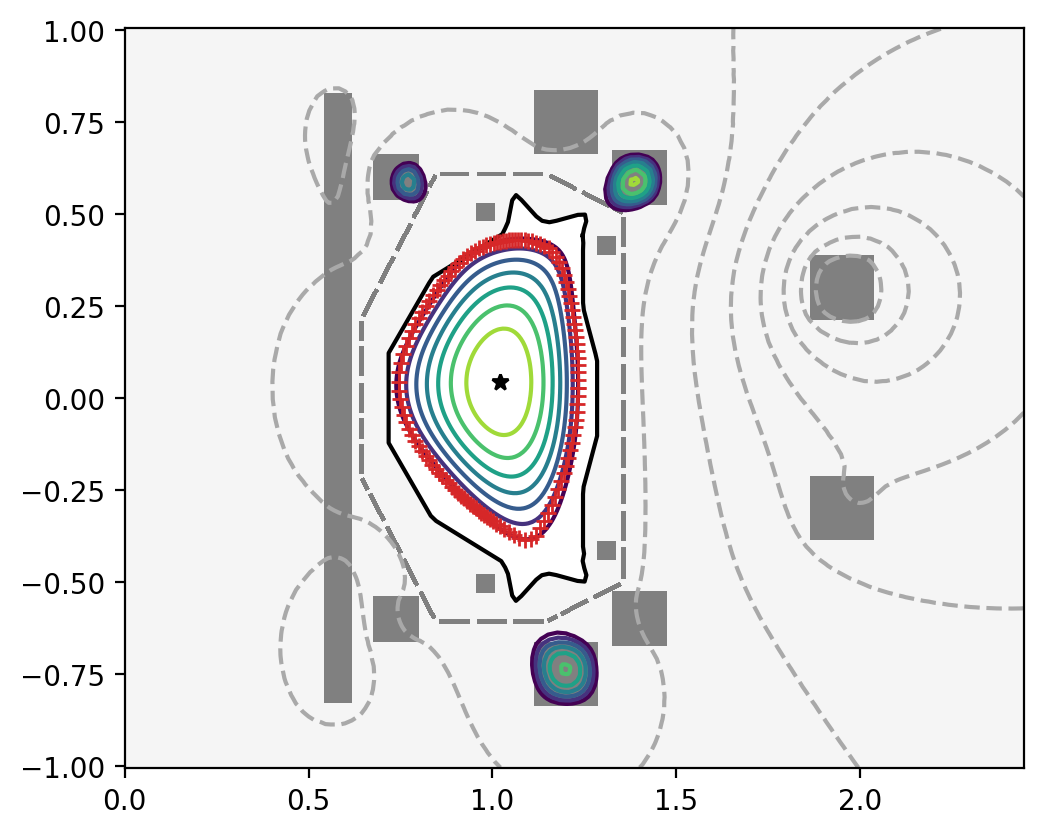

In [11]:
mygs.init_psi(1,0,0.25, 1.7,-0.5)
fig, ax = plt.subplots()
mygs.plot_psi(fig,ax)
mygs.plot_machine(fig,ax)
mygs.plot_constraints(fig,ax)

In [12]:
mygs.solve()
mygs.print_info()

Starting non-linear GS solver
     1  1.6702E+00  2.8395E-06  1.1876E-02  1.0153E+00  4.5604E-02 -0.0000E+00
     2  1.8987E+00  1.5553E-06  4.2679E-03  1.0132E+00  4.6920E-02 -0.0000E+00
     3  1.9674E+00  1.3499E-06  1.4844E-03  1.0122E+00  4.7687E-02 -0.0000E+00
     4  1.9929E+00  1.2947E-06  5.6105E-04  1.0117E+00  4.8207E-02 -0.0000E+00
     5  2.0028E+00  1.2768E-06  2.3344E-04  1.0114E+00  4.8558E-02 -0.0000E+00
     6  2.0067E+00  1.2705E-06  1.0649E-04  1.0113E+00  4.8793E-02 -0.0000E+00
     7  2.0082E+00  1.2681E-06  5.2892E-05  1.0112E+00  4.8948E-02 -0.0000E+00
     8  2.0088E+00  1.2672E-06  2.8256E-05  1.0112E+00  4.9048E-02 -0.0000E+00
     9  2.0090E+00  1.2668E-06  1.5952E-05  1.0111E+00  4.9113E-02 -0.0000E+00
    10  2.0091E+00  1.2667E-06  9.3524E-06  1.0111E+00  4.9154E-02 -0.0000E+00
    11  2.0091E+00  1.2666E-06  5.6173E-06  1.0111E+00  4.9181E-02 -0.0000E+00
    12  2.0091E+00  1.2666E-06  3.4244E-06  1.0111E+00  4.9197E-02 -0.0000E+00
    13  2.0091E+00  1.

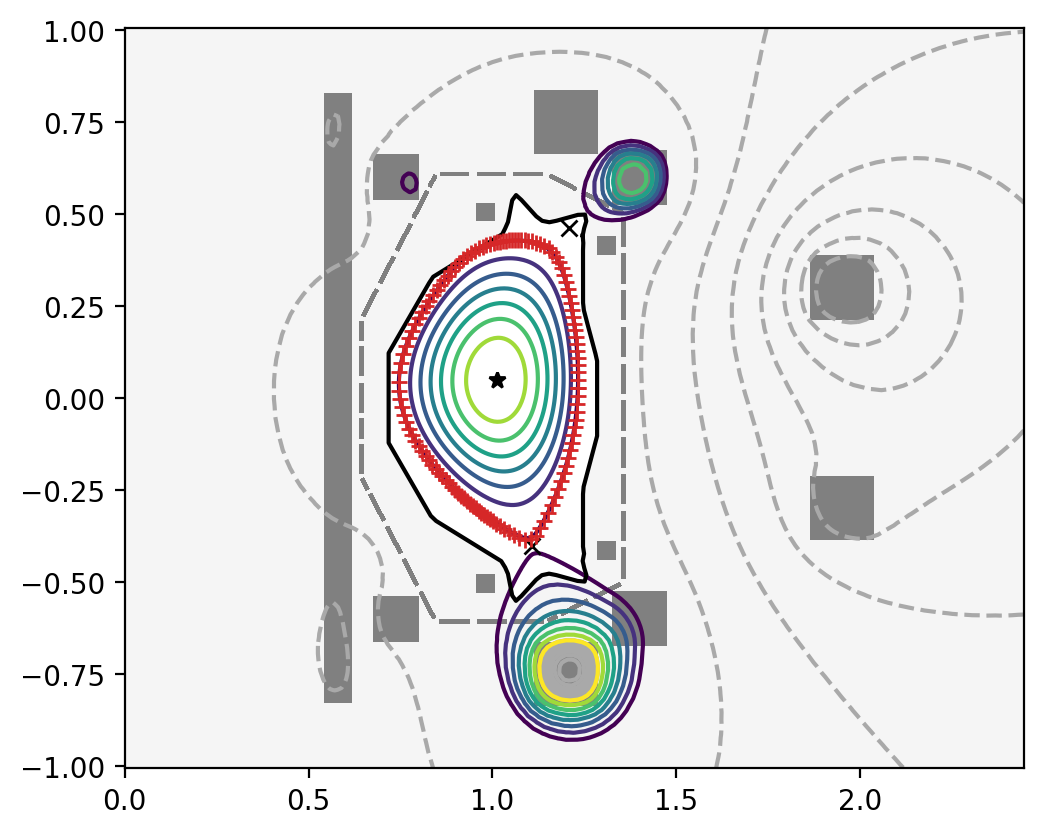

In [13]:
fig, ax = plt.subplots()
mygs.plot_psi(fig,ax)
mygs.plot_machine(fig,ax)
mygs.plot_constraints(fig,ax)

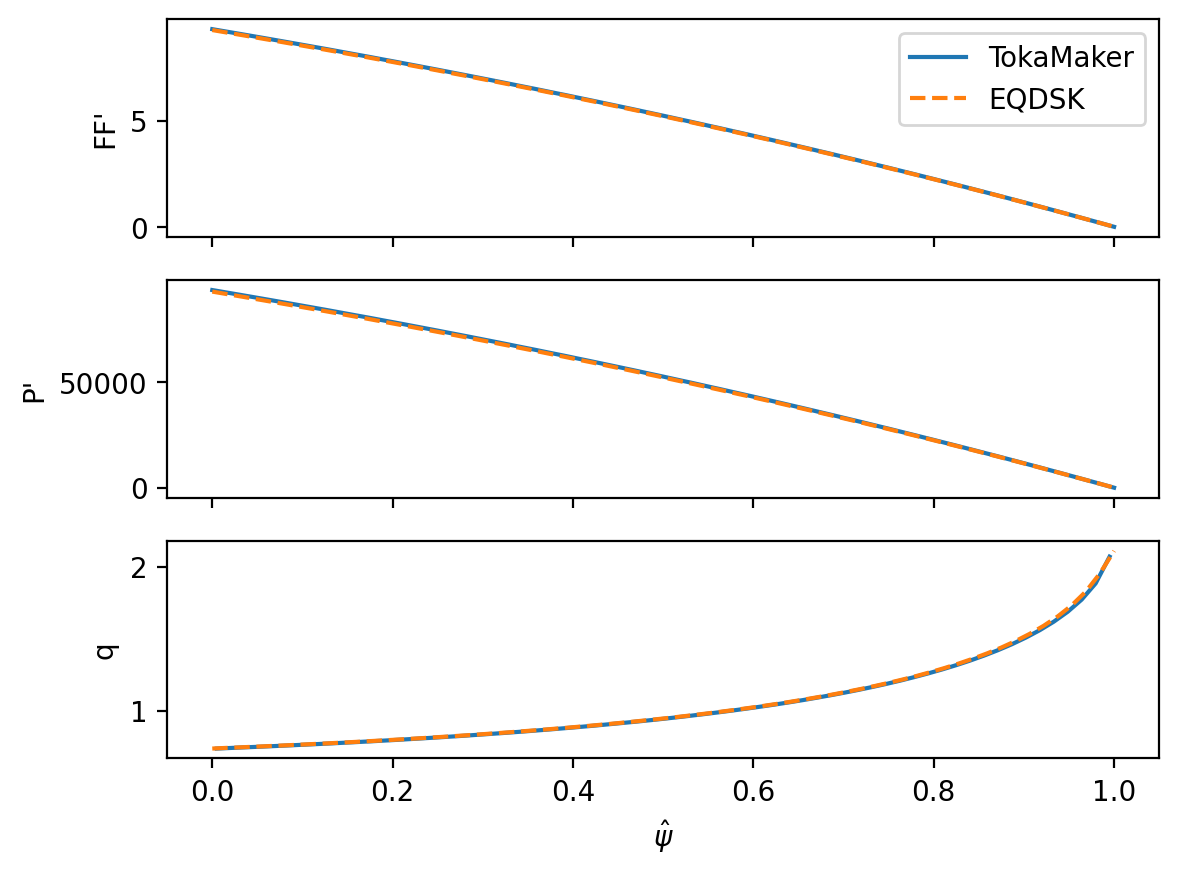

In [14]:
psi,f,fp,p,pp = mygs.get_profiles(npsi=np.size(ffprim))
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi_pad=0.005,npsi=np.size(ffprim))
fig, ax = plt.subplots(3,1,sharex=True)
psi_eqdsk = np.linspace(0.0,1.0,eqdsk['nr'])
psi_sample = np.linspace(0.025,1.0,10)
# Plot F*F'
ax[0].plot(psi,f*fp,label='TokaMaker')
ax[0].plot(psi_eqdsk,eqdsk['ffprim'],'--',label='EQDSK')
ax[0].set_ylabel("FF'")
ax[0].legend()
# Plot P'
ax[1].plot(psi,pp)
ax[1].plot(psi_eqdsk,eqdsk['pprime'],'--')
ax[1].set_ylabel("P'")
# Plot q
ax[2].plot(psi_q,qvals)
ax[2].plot(psi_eqdsk,eqdsk['qpsi'],'--')
ax[2].set_ylabel("q")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

In [15]:
tMaker_currs, _ = mygs.get_coil_currents()
# imap = [0,1,2,3,10,4,9,5,8,6,7,11,12]
for key, coil_set in mygs.coil_sets.items():
    i = coil_set['id']
    if i < len(imap) and imap[i] >= 0:
        print('{2} {0:.3E} {1:.3E}'.format(tMaker_currs[i],coil_currs[imap[i]],key))
    else:
        print('{1} {0:.3E}'.format(tMaker_currs[i],key))

CS_1 -1.537E+06 -1.538E+06
CS_2 7.672E+05 7.676E+05
CS_3 -1.508E+06 -1.508E+06
PF_1U 8.968E+05 8.967E+05
PF_1L 5.437E+05 5.432E+05
PF_2U -8.173E+04 -8.216E+04
PF_2L 6.685E+05 6.676E+05
PF_3U 6.538E+05 6.535E+05
PF_3L 9.932E+04 9.920E+04
PF_4U -1.119E+06 -1.118E+06
PF_4L -3.504E+05 -3.496E+05
DIV_1U -9.361E-04
DIV_1L 3.264E-03
DIV_2U 3.047E-04
DIV_2L -2.465E-04


VDE L/R time = 6.6213E-04 [s]


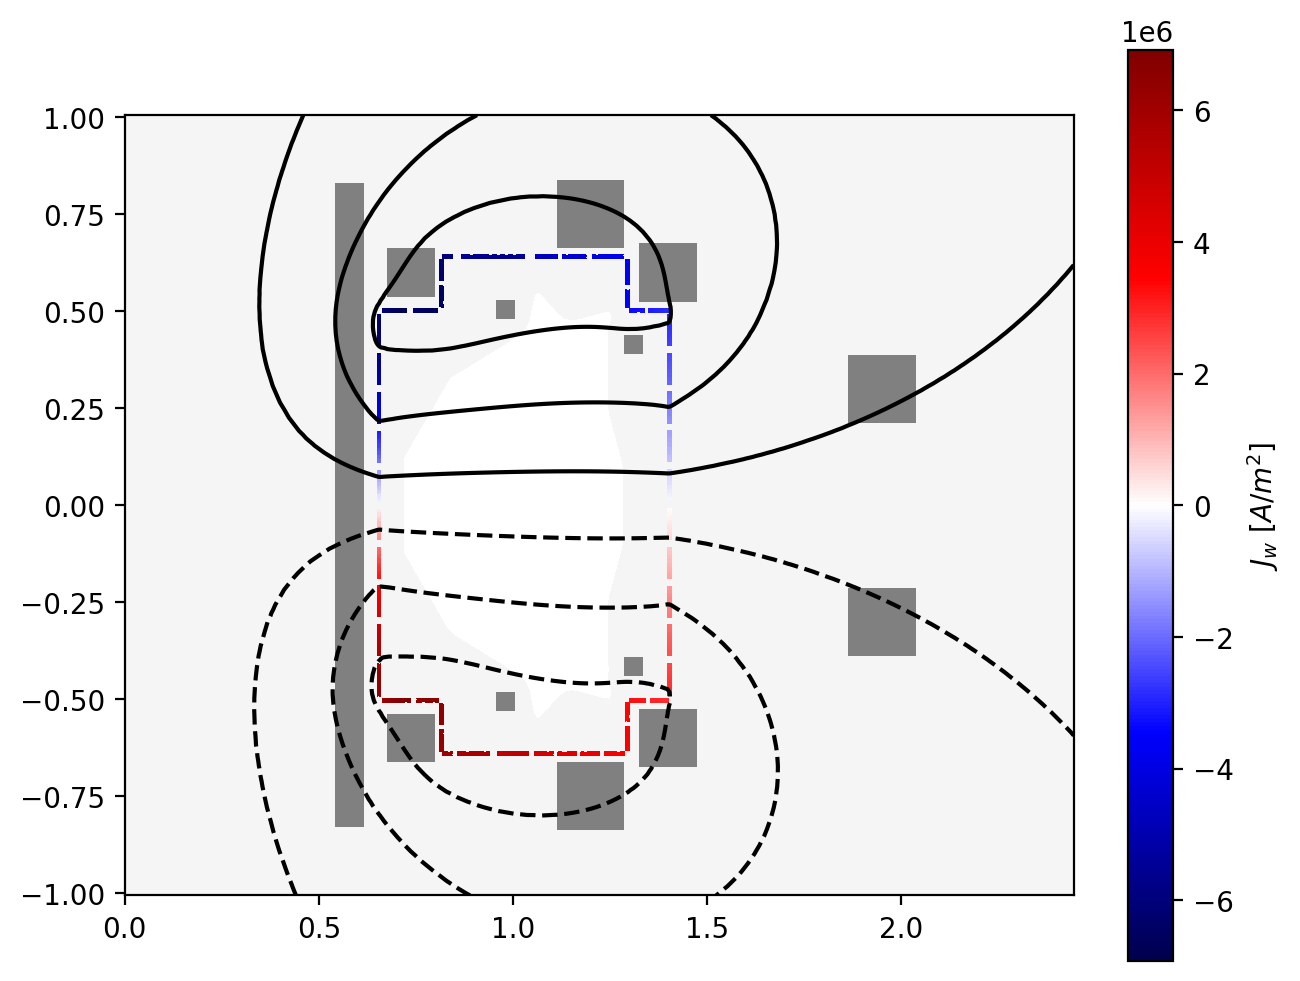

In [16]:
eig_vals, eig_vecs = mygs.eig_wall(10)
tau_wall = 1.0/eig_vals[1,0]
fig, ax = plt.subplots(1,1,constrained_layout=True)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[1,:],xpoint_color=None,opoint_color=None,normalized=False,plasma_color='k')
mygs.plot_eddy(fig,ax,dpsi_dt=eig_vecs[1,:]*abs(eig_vals[1,0]),colormap='seismic',symmap=True)
print('VDE L/R time = {0:.4E} [s]'.format(tau_wall))

Stable!
Decay time  = -1.1535E-03 [s]


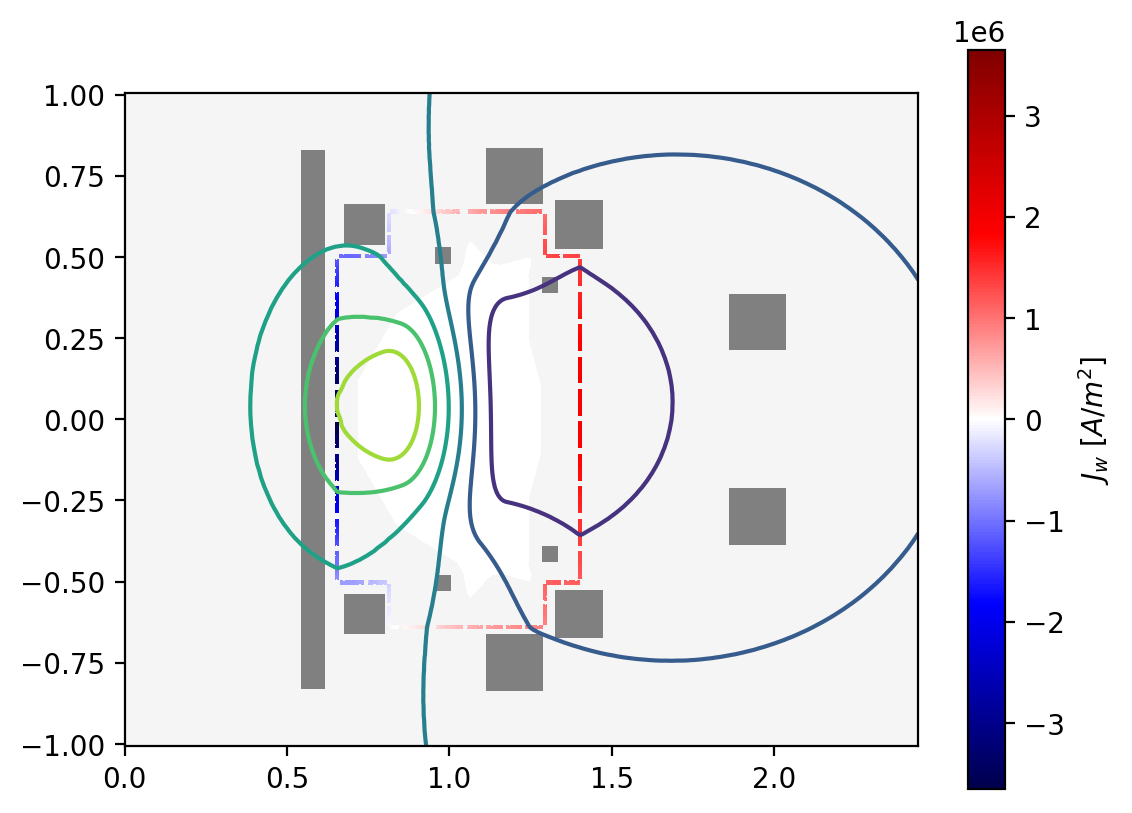

In [17]:
eig_vals, eig_vecs = mygs.eig_td(-5.E6,10,False)
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[0,:],normalized=False,xpoint_color=None,opoint_color=None)
mygs.plot_eddy(fig,ax,dpsi_dt=eig_vecs[0,:]*abs(eig_vals[0,0]),colormap='seismic',symmap=True)
if eig_vals[0,0] < 0.0:
    print('Growth rate = {0:.4E} [s^-1]'.format(-eig_vals[0,0]))
    print('Growth time = {0:.4E} [s]'.format(-1.0/eig_vals[0,0]))
    print('gamma*tau_w = {0:.4E}'.format(-eig_vals[0,0]*tau_wall))
else:
    print('Stable!')
    print('Decay time  = {0:.4E} [s]'.format(-1.0/eig_vals[0,0]))

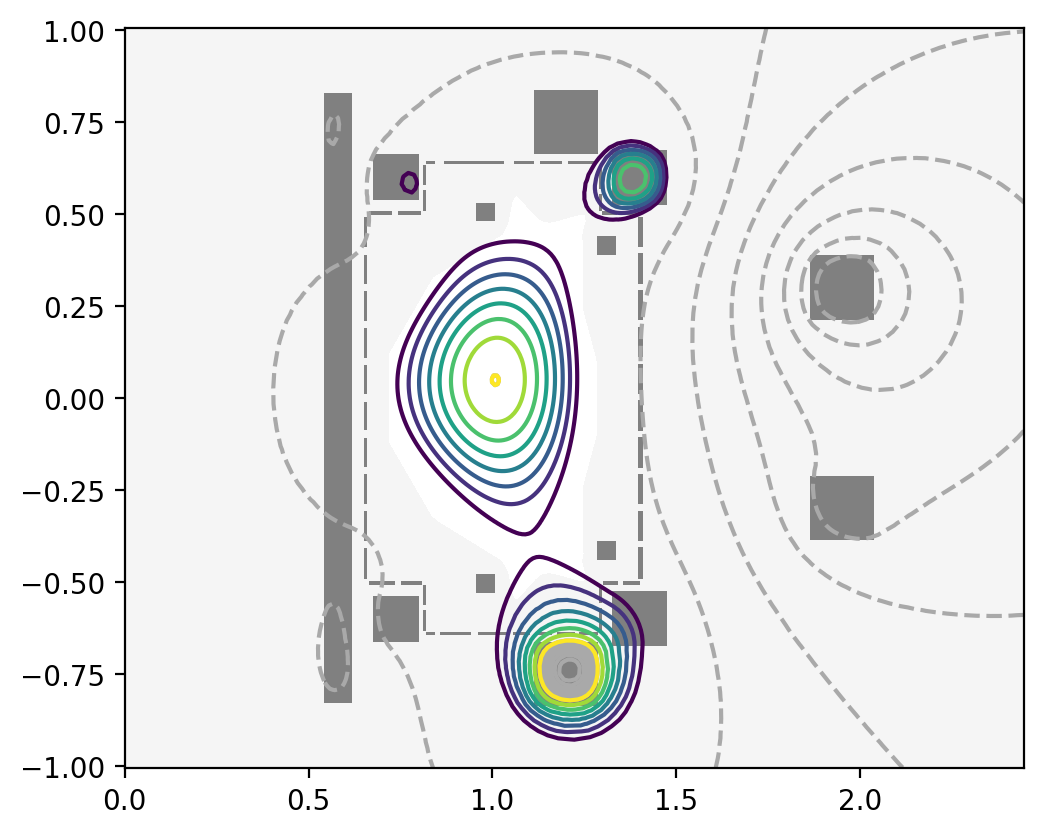

In [18]:
psi0 = mygs.get_psi(normalized = False)
eig_ind = 0
max_loc = abs(eig_vecs[eig_ind,:]).argmax()
psi_ic = psi0+eig_vecs[eig_ind,:]*(mygs.psi_bounds[1]-mygs.psi_bounds[0])/eig_vecs[eig_ind,max_loc]/50.0

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,(psi_ic-mygs.psi_bounds[1])/(mygs.psi_bounds[0]-mygs.psi_bounds[1]),xpoint_color=None,opoint_color=None)
mygs.set_psi(psi_ic)

In [19]:
mygs.settings.pm=False
mygs.update_settings()
mygs.set_isoflux(None)
mygs.set_targets(Ip=eqdsk['ip'],Ip_ratio=5.6)
mygs.setup_td(1.E-03,1.E-13,1.E-11,pre_plasma=False)

In [20]:
import time
sim_time = 0.0
dt = 5.E-2/-eig_vals[0,0]
nplot = 1
nstatus = 2
results = [mygs.get_psi()]
results_raw = [mygs.get_psi(False)]
z0 = [[sim_time,mygs.o_point[1]],]
eig_comp = [[sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)],]
t00 = time.perf_counter()

for i in range(60):
    t0 = time.perf_counter()
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
    t1 = time.perf_counter()
    if i % nstatus == 0:
        print('{0:.5E} {1:.5E} {2:4d} {3:4d} {5:8.3f} {4:4d}'.format(sim_time,dt,nl_its,lin_its,nretry,t1-t0))
    z0.append([sim_time,mygs.o_point[1]])
    eig_comp.append([sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)])
    if i % nplot == 0:
        results.append(mygs.get_psi())
        results_raw.append(mygs.get_psi(False))
t1 = time.perf_counter()
print('Total time = {0:8.3f}'.format(t1-t00))

5.76743E-05 -5.76743E-05    3   25    0.231    0
1.73023E-04 -5.76743E-05    2   16    0.169    0
2.88371E-04 -5.76743E-05    2   16    0.169    0
4.03720E-04 -5.76743E-05    2   16    0.170    0
5.19068E-04 -5.76743E-05    2   16    0.176    0
6.34417E-04 -5.76743E-05    2   16    0.168    0
7.49765E-04 -5.76743E-05    2   15    0.165    0
8.65114E-04 -5.76743E-05    2   14    0.164    0
9.80462E-04 -5.76743E-05    2   15    0.168    0
1.09581E-03 -5.76743E-05    2   15    0.164    0
1.21116E-03 -5.76743E-05    2   15    0.165    0
1.32651E-03 -5.76743E-05    2   14    0.160    0
1.44186E-03 -5.76743E-05    2   15    0.164    0
1.55721E-03 -5.76743E-05    2   15    0.164    0
1.67255E-03 -5.76743E-05    2   12    0.152    0
1.78790E-03 -5.76743E-05    2   13    0.153    0
1.90325E-03 -5.76743E-05    2   13    0.152    0
2.01860E-03 -5.76743E-05    2   10    0.138    0
2.13395E-03 -5.76743E-05    2   13    0.157    0
2.24930E-03 -5.76743E-05    2   11    0.141    0
2.36464E-03 -5.76743

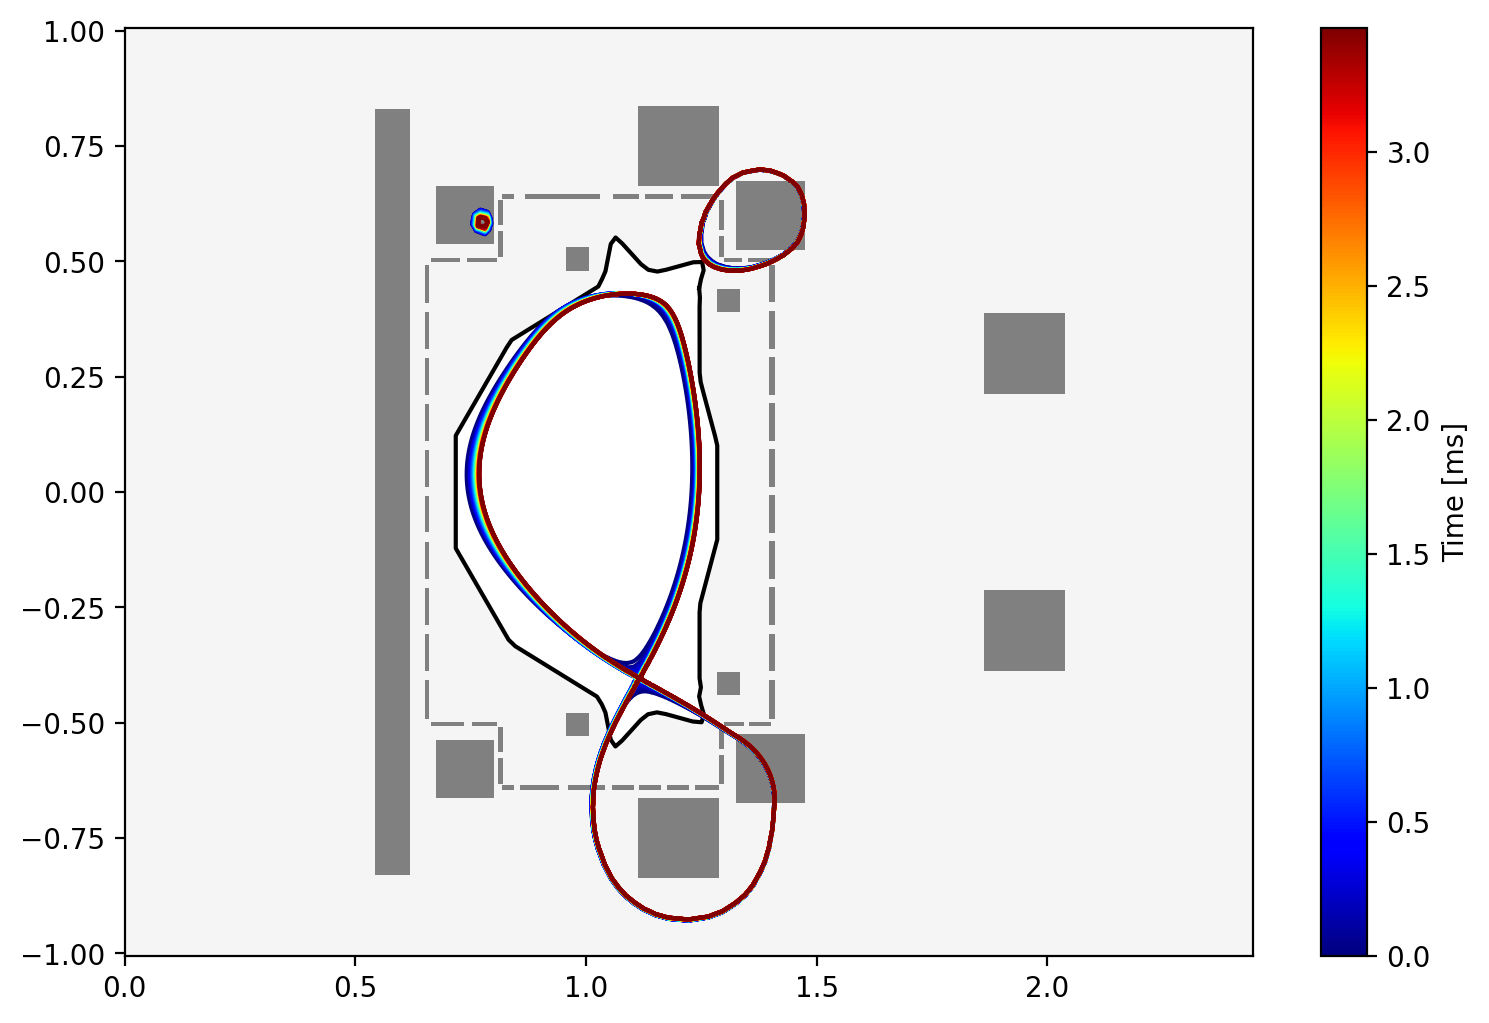

In [21]:
import matplotlib as mpl
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(8,5))
mygs.plot_machine(fig,ax)
colors = plt.cm.jet(np.linspace(0,1,len(results)))
for i, result in enumerate(results):
    mygs.plot_psi(fig,ax,psi=result,plasma_nlevels=1,plasma_color=[colors[i]], vacuum_nlevels = 0,xpoint_color=None,opoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time*1.E3)
_ = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet),ax=ax,label='Time [ms]')

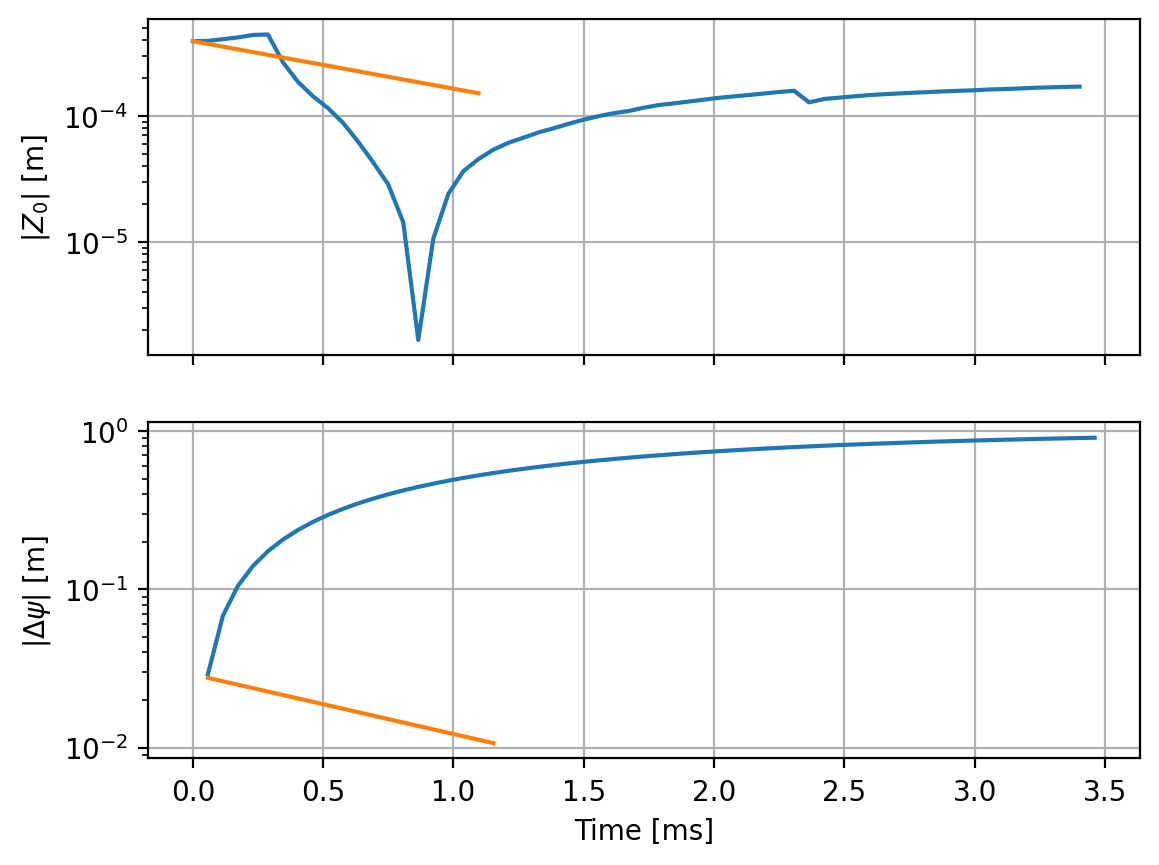

In [22]:
fig, ax = plt.subplots(2,1,sharex=True)
z_hist = np.asarray(z0); z_hist = z_hist[1:,:] - [z_hist[1,0], z_hist[0,1]]
ax[0].semilogy(z_hist[:,0]*1.E3,abs(z_hist[:,1]))
ax[0].semilogy(z_hist[:20,0]*1.E3,abs(z_hist[0,1])*np.exp(-z_hist[:20,0]*eig_vals[0,0]))
ax[0].set_ylabel(r'$|Z_0|$ [m]')
ax[0].grid(True)
eig_hist = np.asarray(eig_comp); eig_hist = eig_hist[1:,:]
ax[1].semilogy(eig_hist[:,0]*1.E3,abs(eig_hist[:,1]))
ax[1].semilogy(eig_hist[:20,0]*1.E3,abs(eig_hist[0,1])*np.exp(-eig_hist[:20,0]*eig_vals[0,0]))
ax[1].set_ylabel(r'$|\Delta \psi|$ [m]')
ax[1].grid(True)
_ = ax[-1].set_xlabel(r'Time [ms]')